# TRAIN A MULTI LAYER PERCEPTRON 
(L-LAYER DENSE FEEDFORWARD NEURAL NETWORK)

In this notebook, we will implement and train a multi layer perceptron, another term for "L-layer dense feedforward neural network".

- L-layer: a neural network with (L-1) hidden layers and 1 output layer
- dense: all neurons of layer L are connected to all neurons of layer (L-1)
- feedforward: forward propagation goes from layer 1 to layer L, left to right (no recursion or connections between layers that aren't direct neighbours)

---

**IMPORTANT**: for all the neural networks we will implement, **we will go through the same 12 steps**:

- load the dataset (**load_data**)

- visualize it (**visualize_data**)
- preprocess the dataset (**preprocess_data**)
- define the network structure (**get_layer_sizes**)
- initialize the parameters (**initialize_params**)
- define the forward propagation step (**forward_propagate**)
- calculate the cost (**compute_cost**)
- define the backward propagation step (**backward_propagate**)
- update the model parameters (**update_params**)
- integrate all the steps in a training function (**train**)
- predict on new elements (**predict**)
- evaluate the performance of the model (**evaluate_performance**)

---

In the second part of the notebook, we will experiment with hyperparameters, in particular the number of iterations and the learning rate


Ready ? Let's go !

In [1]:
from pathlib import Path
import joblib
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import sys
from typing import Union
sys.path.append('..')
from utils.planar_utils import load_planar_dataset
from testCases_v4a import *

np.random.seed(42)

## helper functions

In [2]:
def sigmoid(Z: Union[np.array, float]) -> Union[np.array, float]:
    """The sigmoid function.
    Args:
        - z: a numpy array or float
    Returns:
        - sigmoid(z)
    """
    return 1 / (1 + np.exp(-Z))

In [3]:
def relu(Z: Union[np.array, float]) -> Union[np.array, float]:
    return np.maximum(Z, 0)

## load data

In [4]:
## CATVSNONCAT DATASET ##
###########################
def load_data():
    """
    Load the train and test set.

    Returns:
        - (X_train, Y_train, X_test, Y_test)
    """

    path = Path('../../data/catvnoncat/data.pkl')
    with open(path, "rb") as f:
        data = joblib.load(f)

    X_train = data["train_set_x"]
    Y_train = data["train_set_y"]
    X_test = data["test_set_x"]
    Y_test = data["test_set_y"]

    return X_train, Y_train, X_test, Y_test
############################
############################

In [5]:
# ## FLOWER DATASET ## 
# ####################

# def load_data():
#     """
#     Load the train and test set.

#     Returns:
#         - (X_train, Y_train, X_test, Y_test)
#     """

#     X, Y = load_planar_dataset()

#     ## train / test split
#     m = X.shape[1]
#     pct_test = 0.20
#     m_test = int(m * pct_test)
#     idx_test = np.random.choice(m, size=m_test, replace=False)
#     idx_train = [i for i in range(m) if i not in idx_test]
#     X_train = X[:, idx_train]
#     Y_train = Y[:, idx_train]
#     X_test = X[:, idx_test]
#     Y_test = Y[:, idx_test]

#     return X_train, Y_train, X_test, Y_test

# ####################
# ####################

In [6]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig = load_data()

print(f"X_train_orig shape: {X_train_orig.shape}")
print(f"Y_train_orig shape: {Y_train_orig.shape}")
print(f"X_test_orig shape: {X_test_orig.shape}")
print(f"Y_test_orig shape: {Y_test_orig.shape}")

X_train_orig shape: (209, 64, 64, 3)
Y_train_orig shape: (209,)
X_test_orig shape: (50, 64, 64, 3)
Y_test_orig shape: (50,)


## visualize data

In [7]:
## CATVSNONCAT DATASET ##
#########################
def visualize_data(X, Y):
    """
    Displays a random image from the CATVNONCAT dataset with its label
    """
    m = X.shape[0]
    i = random.randint(0, m-1)
    x = X[i]
    y = Y[i]
    labels = {0: "non-cat", 1: "cat"}
    print(f'label: {labels[y]}')
    plt.imshow(x)
####################
####################

In [8]:
# ## FLOWER DATASET ##
# ####################
# def visualize_data(X, Y):
#     """
#     Renders the flower dataset as a matplotlib figure.
#     """
#     plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.cividis)
# ####################
# ####################

label: non-cat


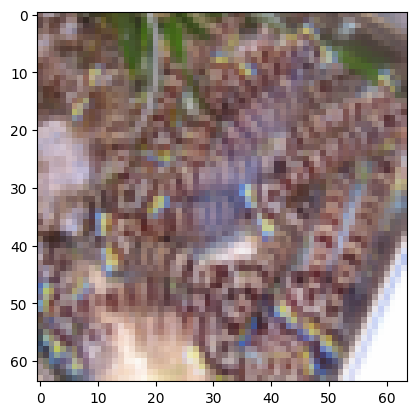

In [9]:
visualize_data(X_train_orig, Y_train_orig)

## preprocess data

In [10]:
## CATVSNONCAT DATASET ##
#########################
def preprocess_data(X, Y = None):
    """Preprocess input data, in order to be fed as the input of the neural network.
    
    Operations:
        - Reshaping of the arrays to fit the Neural Network Input
        - Normalization
    Returns:
        (X_pp, Y_pp)
        
        using the following notations:
        - n_x: number of features in the input of the neural network
        - m: number of observations 
        X_pp: normalized matrix of size (n_x, m)
        Y_pp: normalized array of size (1, m)
    """
    m = X.shape[0]

    ## Reshape the arrays
    ### START CODE ###
    X = X.reshape(m, -1).T
    if Y is not None:
        Y = Y.reshape(m, 1).T
    ### END CODE ###

    ## normalization
    ### START CODE ###
    X = X / 255.
    ### END CODE ###
    return X,Y

####################
####################

In [11]:
# ## FLOWER DATASET ## 
# ####################
# def preprocess_data(X, Y = None):
#     """Preprocess input data, in order to be fed as the input of the neural network.
#     """
#     # nothing to do, the data is already in the right shape and scale !
#     return X, Y
# ###################
# ###################

In [12]:
X_train, Y_train = preprocess_data(X_train_orig, Y_train_orig)
X_test, Y_test = preprocess_data(X_test_orig, Y_test_orig)

print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (12288, 209)
Y_train shape: (1, 209)
X_test shape: (12288, 50)
Y_test shape: (1, 50)


## define the network structure

We want to build a logistic regression, which can be seen as the following 1-layer neural network:

![SCHEMA OF L-LAYER PERCEPTRON]()

In [13]:
def get_layer_sizes(X, nb_hidden_layers, nb_hidden_units):
    """
    Get the number of layers as well as the size of each neural network layer.
    Here each hidden 
    The last layer has 1 unit, as we are performing binary classification.

    Returns:
        - n: list. Number of units per layer. n[0]: number of input features, n[1]: number of hidden units for layer 1, etc.
    """
    ### START CODE ###
    n = list()
    n_0 = X.shape[0]
    n.append(n_0)
    for i in range(nb_hidden_layers):
        n.append(nb_hidden_units)

    # last layer: 1 hidden unit
    n.append(1)
    
    ### END CODE ###
    return n



In [14]:
n = get_layer_sizes(X_train, 1, 3)
print(n)


[12288, 3, 1]


## initialize the parameters

In [58]:
def initialize_params(n: list[int]):
    """Initialize the MLP parameters.
    
    Args:
        - n: number of hidden units per layer
    
    Returns:
        - params: a dictionary of the model parameters: {"W": W, "b": b}
    """
    params = dict()

    for i in range(1, len(n)):
        params[f"W{i}"] = np.random.randn(n[i], n[i-1]) * 0.001
        params[f"b{i}"] = np.zeros((n[i], 1))
    
    return params

In [59]:
params = initialize_params(n)

In [60]:
params['W1']

array([[ 4.18443700e-05, -4.77750452e-04, -1.30053305e-03, ...,
         7.41264734e-05,  3.39541466e-04,  3.30316239e-04],
       [-1.69164124e-03, -1.10679804e-04,  3.67636444e-04, ...,
        -7.59687809e-05, -3.68200239e-04,  2.54110328e-03],
       [-7.94663400e-04, -2.07053419e-04, -6.21477214e-04, ...,
         9.64767661e-04, -7.61089843e-04,  4.30274045e-04]])

## forward propagate

In [61]:
def forward_propagate_1layer(A_prev, W, b, activation):
    """Forward propagation for 1 layer
    """
    Z = np.dot(W, A_prev) + b
    if activation == "sigmoid":
        A = sigmoid(Z)
    elif activation == "relu":
        A = relu(Z)
    cache = (A_prev, W, b, Z)
    return A, cache


In [62]:
## TESTS
A_prev_t, W_t, b_t = linear_activation_forward_test_case()
A_t, cache_t = forward_propagate_1layer(A_prev_t, W_t, b_t, "sigmoid")
print("With sigmoid: A = " + str(A_t))
A_t, cache_t = forward_propagate_1layer(A_prev_t, W_t, b_t, "relu")
print("With ReLU: A = " + str(A_t))

With sigmoid: A = [[0.96890023 0.11013289]]
With ReLU: A = [[3.43896131 0.        ]]


**Expected output**:
       
<table style="width:35%">
  <tr>
    <td> **With sigmoid: A ** </td>
    <td > [[ 0.96890023  0.11013289]]</td> 
  </tr>
  <tr>
    <td> **With ReLU: A ** </td>
    <td > [[ 3.43896131  0.        ]]</td> 
  </tr>
</table>

In [63]:
def forward_propagate(params, X):
    """Perform the forward propagation operation.
    
    Args:
        - params: a dictionary of the model parameters: {"W": W, "b": b}
        - X: a dataset of observation (shape: n_0, m)

    Returns:
        - Al: the matrix of activations of the output layer
    """
    ### START CODE ###
    A_prev = X
    caches = list()
    l = len(params) // 2

    for k in range(1, l):
        W = params[f"W{k}"]
        b = params[f"b{k}"]
        A, cache = forward_propagate_1layer(A_prev, W, b, activation="relu")
        caches.append(cache)
        A_prev = A

    Wl = params[f"W{l}"]
    bl = params[f"b{l}"]
    Al, cache = forward_propagate_1layer(A_prev, Wl, bl, activation="sigmoid")
    caches.append(cache)
    ### END CODE ###

    return Al, caches

In [64]:
Al, caches = forward_propagate(params, X_train)

In [65]:
## TESTS
X_t, params_t = L_model_forward_test_case_2hidden()
Al_t, caches_t = forward_propagate(params_t, X_t)
print("Al = " + str(Al_t))
print("Length of caches list = " + str(len(caches_t)))

Al = [[0.03921668 0.70498921 0.19734387 0.04728177]]
Length of caches list = 3


<table style="width:50%">
  <tr>
    <td> **AL** </td>
    <td > [[ 0.03921668  0.70498921  0.19734387  0.04728177]]</td> 
  </tr>
  <tr>
    <td> **Length of caches list ** </td>
    <td > 3 </td> 
  </tr>
</table>

## compute the cost

In [66]:
def compute_cost(A, Y):
    """Compute the cost of the output layer activation.
    
    Args:
        - A: the matrix of activations of the output layer. Shape: (n_1,m)
        - Y: ground truths. Shape: (n_1,m)
    """
    ### START CODE ###
    m = A.shape[1]
    cost = -(1/m)*np.sum(Y*np.log(A) + (1-Y)*np.log(1-A))
    ### END CODE ###
    
    return cost

In [67]:
compute_cost(Al, Y_train)

0.6931471940851603

In [68]:
## TESTS
Y_t, Al_test = compute_cost_test_case()
print("cost = " + str(compute_cost(Al_test, Y_t)))

cost = 0.2797765635793422


**Expected Output**:
<table>
    <tr>
    <td>**cost** </td>
    <td> 0.2797765635793422</td> 
    </tr>
</table>

## backward propagate

In [69]:
def backward_propagate_1layer(dA, cache, activation):

    A_prev = cache[0]
    W = cache[1]
    Z = cache[3]
    
    if activation == "relu":
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0
    if activation == "sigmoid":
        dZ = dA * sigmoid(Z) * (1 - sigmoid(Z))
    
    m = dA.shape[1]
    dW = (1/m) * np.dot(dZ, A_prev.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db

In [70]:
## TESTS
dAl_t, la_cache_t = linear_activation_backward_test_case()
cache_t = (la_cache_t[0][0], la_cache_t[0][1], la_cache_t[0][2], la_cache_t[1])

print(f"dAl: {dAl_t}")
print(f"Z: {cache_t[-1]}")
dA_prev_t, dW_t, db_t = backward_propagate_1layer(dAl_t, cache_t, activation = "sigmoid")
print ("sigmoid:")
print ("dA_prev = "+ str(dA_prev_t))
print ("dW = " + str(dW_t))
print ("db = " + str(db_t) + "\n")

dA_prev_t, dW_t, db_t = backward_propagate_1layer(dAl_t, cache_t, activation = "relu")
print ("relu:")
print ("dA_prev = "+ str(dA_prev_t))
print ("dW = " + str(dW_t))
print ("db = " + str(db_t))

dAl: [[-0.41675785 -0.05626683]]
Z: [[ 0.04153939 -1.11792545]]
sigmoid:
dA_prev = [[ 0.11017994  0.01105339]
 [ 0.09466817  0.00949723]
 [-0.05743092 -0.00576154]]
dW = [[ 0.10266786  0.09778551 -0.01968084]]
db = [[-0.05729622]]

relu:
dA_prev = [[ 0.44090989  0.        ]
 [ 0.37883606  0.        ]
 [-0.2298228   0.        ]]
dW = [[ 0.44513824  0.37371418 -0.10478989]]
db = [[-0.20837892]]


**Expected output with sigmoid:**

<table style="width:100%">
  <tr>
    <td>
        dA_prev
     </td> 
     <td>
         [[ 0.11017994  0.01105339]
         [ 0.09466817  0.00949723]
         [-0.05743092 -0.00576154]]
      </td> 
  </tr> 
    <tr>
        <td>
            dW
        </td> 
        <td>
            [[ 0.10266786  0.09778551 -0.01968084]]
        </td> 
  </tr> 
    <tr>
        <td>
        db
       </td> 
       <td >
           [[-0.05729622]]
        </td> 
  </tr> 
</table>

**Expected output with reLU:**

<table style="width:100%">
  <tr>
    <td>
        dA_prev
     </td> 
     <td>
         [[ 0.44090989  0.        ]
          [ 0.37883606  0.        ]
          [-0.2298228   0.        ]]
      </td> 
  </tr> 
    <tr>
        <td>
            dW
        </td> 
        <td>
            [[ 0.44513824  0.37371418 -0.10478989]]
        </td> 
  </tr> 
    <tr>
        <td>
        db
       </td> 
       <td >
           [[-0.20837892]]
        </td> 
  </tr> 
</table>

In [71]:
n = [X_train.shape[0], 5, 3, 1]

In [72]:
def backward_propagate(Al, Y, caches):
    """The Backward propagation operation.

    """
    ### START CODE ###
    grads = dict()
    l = len(caches)
    m = Al.shape[1]
    dAl = - (np.divide(Y, Al) - np.divide(1-Y, 1-Al))


    ## backward propagation on the output layer
    current_cache = caches[l-1] # Last Layer
    grads["dA" + str(l-1)], grads["dW" + str(l)], grads["db" + str(l)] = backward_propagate_1layer(dAl, current_cache, "sigmoid")
    
    ## backward propagation on the hidden layers
    for k in reversed(range(l-1)):
        current_cache = caches[k]
        dA_prev, dW, db = backward_propagate_1layer(grads[f"dA{k+1}"], current_cache, "relu")
        grads[f"dA{k}"] = dA_prev
        grads[f"dW{k+1}"] = dW
        grads[f"db{k+1}"] = db
    
    ### END CODE ###
    return grads

In [73]:
grads = backward_propagate(Al, Y_train, caches)

In [74]:
## TESTS
Al_t, Y_assess_t, caches_t = L_model_backward_test_case()
new_caches_t = ((caches_t[0][0][0], caches_t[0][0][1], caches_t[0][0][2], caches_t[0][1]),
                (caches_t[1][0][0], caches_t[1][0][1], caches_t[1][0][2], caches_t[1][1]))
grads_t = backward_propagate(Al_t, Y_assess_t, new_caches_t)
print_grads(grads_t)

dW1 = [[0.41010002 0.07807203 0.13798444 0.10502167]
 [0.         0.         0.         0.        ]
 [0.05283652 0.01005865 0.01777766 0.0135308 ]]
db1 = [[-0.22007063]
 [ 0.        ]
 [-0.02835349]]
dA1 = [[ 0.12913162 -0.44014127]
 [-0.14175655  0.48317296]
 [ 0.01663708 -0.05670698]]


**Expected Output**

<table style="width:60%">
  
  <tr>
    <td > dW1 </td> 
          <td > [[ 0.41010002  0.07807203  0.13798444  0.10502167]
 [ 0.          0.          0.          0.        ]
 [ 0.05283652  0.01005865  0.01777766  0.0135308 ]] </td> 
  </tr> 
  
  <tr>
    <td > db1 </td> 
          <td > [[-0.22007063]
 [ 0.        ]
 [-0.02835349]] </td> 
  </tr> 
  
  <tr>
  <td > dA1 </td> 
           <td > [[ 0.12913162 -0.44014127]
 [-0.14175655  0.48317296]
 [ 0.01663708 -0.05670698]] </td> 

  </tr> 
</table>



## update the parameters

In [75]:
def update_params(params, grads, learning_rate):
    """Update weights using gradient descent.
    
    Args:
        - params: a dictionary of the model parameters: {"W": W, "b": b}
        - grads: a dictionary containing the gradients for all model parameters. {"dW": dW, "db": db}
        - learning_rate: the learning rate (float number)
    Returns:
        - params: a dictionary of the model parameters updated: {"W": W, "b": b}
    """
    ### START CODE ###
    l = len(params) // 2

    for k in range(l):
        params[f"W{k+1}"] = params[f"W{k+1}"] - learning_rate * grads[f"dW{k+1}"]
        params[f"b{k+1}"] = params[f"b{k+1}"] - learning_rate * grads[f"db{k+1}"]
    ### START CODE ###
    
    return params

In [76]:
params = update_params(params, grads, 0.01)

In [77]:
## TESTS
parameters_t, grads_t = update_parameters_test_case()
parameters_t = update_params(parameters_t, grads_t, 0.1)

print ("W1 = "+ str(parameters_t["W1"]))
print ("b1 = "+ str(parameters_t["b1"]))
print ("W2 = "+ str(parameters_t["W2"]))
print ("b2 = "+ str(parameters_t["b2"]))

W1 = [[-0.59562069 -0.09991781 -2.14584584  1.82662008]
 [-1.76569676 -0.80627147  0.51115557 -1.18258802]
 [-1.0535704  -0.86128581  0.68284052  2.20374577]]
b1 = [[-0.04659241]
 [-1.28888275]
 [ 0.53405496]]
W2 = [[-0.55569196  0.0354055   1.32964895]]
b2 = [[-0.84610769]]


**Expected Output**:

<table style="width:100%"> 
    <tr>
      <td >
        W1
      </td> 
      <td > 
        [[-0.59562069 -0.09991781 -2.14584584  1.82662008]
        [-1.76569676 -0.80627147  0.51115557 -1.18258802]
        [-1.0535704  -0.86128581  0.68284052  2.20374577]] 
      </td> 
    </tr> 
    <tr>
      <td >
        b1
      </td> 
      <td >
        [[-0.04659241]
        [-1.28888275]
        [ 0.53405496]]
      </td> 
    </tr> 
    <tr>
      <td >
        W2
      </td> 
      <td >
        [[-0.55569196  0.0354055   1.32964895]]
      </td> 
    </tr> 
    <tr>
      <td >
        b2
      </td> 
      <td > 
        [[-0.84610769]]
      </td> 
    </tr> 
</table>


## train

In [88]:
def train(X, Y, n: list[int], nb_iterations: int, learning_rate: float):
    """Combines all the operations necessary to train the logistic regression.
    
    Args:
        - X: the matrix of observations. Shape: (n_0, m)
        - Y: ground truths. Shape: (n_1, m)
        - n: number of units per layer.
            --> l = len(n) - 1 (we don't count the input layer)
            --> n[i] = number of units in layer i
        - nb_iterations: number of iterations to perform gradient descent
        - learning_rate: the learning rate (float number)

    Returns:
        - (params, cost) with:
            - params: dictionary of the model parameters: {"W": W, "b": b}
            - costs: list of the costs for each 100th iteration (iteration 1, iteration 100, etc.)
    """
    
    ### START CODE ###
    params = initialize_params(n)
    costs = list()
    grads_list = list()
    params_list = list()
    for i in range(nb_iterations):
        Al, caches = forward_propagate(params, X)
        cost = compute_cost(Al, Y)
        grads = backward_propagate(Al, Y, caches)
        params = update_params(params, grads, learning_rate)

        if (i % 100) == 0:# we store the cost each 100 iterations
            costs.append(cost)
            grads_list.append(grads)
            params_list.append(params)
    ### START CODE ###
    
    return params, costs, grads_list, params_list

In [105]:
#n = get_layer_sizes(X_train, nb_hidden_layers=1, nb_hidden_units=7)
#n = [X_train.shape[0], 5, 3, 1]
n = [X_train.shape[0], 3, 1]
#n = [X_train.shape[0], 3, 2, 1]
#nb_it = 4000
nb_it = 2500
#learning_rate = 0.01
learning_rate = 0.0075
params, costs, grads_list, params_list = train(X_train, Y_train, n, nb_it, learning_rate)

In [112]:
params

{'W1': array([[-1.40195444e-02,  1.85374482e-02, -1.65843303e-03, ...,
         -8.65861260e-04,  1.11761623e-02, -3.04296126e-02],
        [ 5.11034311e-04,  1.61419866e-03, -2.50182659e-04, ...,
         -1.62703176e-03, -8.76738363e-04,  1.31224276e-05],
        [-5.28854293e-04, -4.77092157e-04, -1.33681966e-03, ...,
          8.02601168e-04, -2.09813917e-04, -9.21203453e-04]]),
 'b1': array([[6.17968139e-02],
        [2.66363305e-04],
        [9.84289341e-06]]),
 'W2': array([[-1.51961875e+00, -4.57515424e-02, -4.79423100e-04]]),
 'b2': array([[0.88527902]])}

[12288, 3, 1]


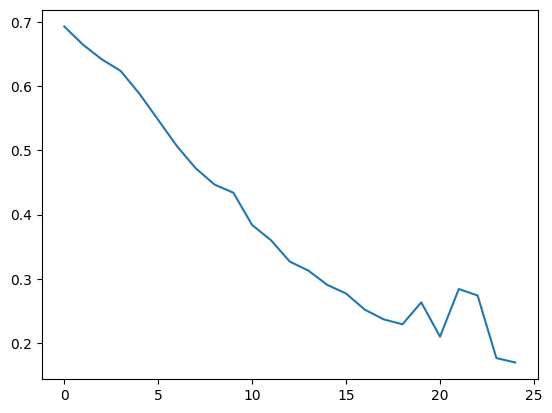

In [106]:
print(n)
plt.plot(costs)

In [91]:
# el = "db3"
# for i in range(len(grads_list)):
#     a1 = grads_list[0][el]
#     a2 = grads_list[1][el]
#     print(a2-a1)
#     print('___')

In [115]:
el = "b1"
for i in range(len(params_list)-1):
    a1 = params_list[i][el]
    a2 = params_list[i+1][el]
    print(a1)
    #print(a2-a1)
    print('___')

[[6.17968139e-02]
 [2.66363305e-04]
 [9.84289341e-06]]
___
[[6.17968139e-02]
 [2.66363305e-04]
 [9.84289341e-06]]
___
[[6.17968139e-02]
 [2.66363305e-04]
 [9.84289341e-06]]
___
[[6.17968139e-02]
 [2.66363305e-04]
 [9.84289341e-06]]
___
[[6.17968139e-02]
 [2.66363305e-04]
 [9.84289341e-06]]
___
[[6.17968139e-02]
 [2.66363305e-04]
 [9.84289341e-06]]
___
[[6.17968139e-02]
 [2.66363305e-04]
 [9.84289341e-06]]
___
[[6.17968139e-02]
 [2.66363305e-04]
 [9.84289341e-06]]
___
[[6.17968139e-02]
 [2.66363305e-04]
 [9.84289341e-06]]
___
[[6.17968139e-02]
 [2.66363305e-04]
 [9.84289341e-06]]
___
[[6.17968139e-02]
 [2.66363305e-04]
 [9.84289341e-06]]
___
[[6.17968139e-02]
 [2.66363305e-04]
 [9.84289341e-06]]
___
[[6.17968139e-02]
 [2.66363305e-04]
 [9.84289341e-06]]
___
[[6.17968139e-02]
 [2.66363305e-04]
 [9.84289341e-06]]
___
[[6.17968139e-02]
 [2.66363305e-04]
 [9.84289341e-06]]
___
[[6.17968139e-02]
 [2.66363305e-04]
 [9.84289341e-06]]
___
[[6.17968139e-02]
 [2.66363305e-04]
 [9.84289341e-06]]
_

In [50]:

a1 = grads_list[0]["dA2"]
a2 = grads_list[1]["dA2"]

In [51]:
a1-a2

array([[ 2.65938089e-05,  2.65938089e-05, -1.58047322e-04,
         2.65938089e-05,  2.65938089e-05,  2.65936853e-05,
         2.65938089e-05, -1.58047446e-04,  2.65938089e-05,
         2.65938089e-05,  2.65938089e-05, -1.58047322e-04,
         2.65938089e-05, -1.58047322e-04, -1.58048085e-04,
         2.65937880e-05,  2.65938089e-05,  2.65934936e-05,
         2.65938089e-05, -1.58047322e-04,  2.65938089e-05,
         2.65938089e-05,  2.65938089e-05,  2.65936853e-05,
        -1.58047322e-04, -1.58047446e-04,  2.65931740e-05,
        -1.58047322e-04,  2.65926646e-05, -1.58047322e-04,
         2.65912840e-05,  2.65938089e-05,  2.65926384e-05,
         2.65938089e-05,  2.65938089e-05,  2.65938089e-05,
         2.65938089e-05,  2.65938089e-05, -1.58047322e-04,
         2.65936853e-05,  2.65938089e-05, -1.58047322e-04,
        -1.58047682e-04,  2.65938089e-05,  2.65936853e-05,
         2.65938089e-05,  2.65938089e-05, -1.58047727e-04,
         2.65938089e-05,  2.65938089e-05, -1.58047322e-0

## predict

In [ ]:
def predict(params, X, threshold = 0.5):
    """Predicts the output of the logistic regression.

    Args:
        - params: dictionary of the model parameters: {"W": W, "b": b}
        - X: a matrix of observations. Shape: (n_0, ?)
        - threshold: threshold to use for the prediction (default 0.5 means: if p >= 0.5, we predict 1, else 0)
    
    Returns:
        - Yp: vector of predictions.
    """
    ### START CODE ###
    Al, caches = forward_propagate(params, X)
    Yp = 1*(Al >= threshold)
    ### START CODE ###

    return Yp

In [ ]:
predict(params, X_train)

## evaluate the performance

In [ ]:
def evaluate_performance(X_train, Y_train, X_test, Y_test, params, print_perf=True):
    """Evaluates the performance of the logistic regression.
    
    Args:
        - X_train: matrix of observations for the training set
        - Y_train: ground truths for the training set
        - X_test: matrix of observations for the test set
        - Y_test: ground truths for the test set
        - params: the logistic regression parameters
        - print_perf: boolean. If true, prints the performance on the train and test set, as well as the baseline performance.

    Returns:
        - (acc_train, acc_test) where:
            - acc_train: accuracy on the train set
            - acc_test: accuracy on the test set
    """
    ### START CODE ###
    Yp_train = predict(params, X_train)
    Yp_test = predict(params, X_test)
    
    acc_train = np.mean(Yp_train == Y_train)
    acc_test = np.mean(Yp_test == Y_test)

    if print_perf:
        print(f'train accuracy: {acc_train:.1%}')
        print(f'test accuracy: {acc_test:.1%}')
        print("")
        
        acc_bs_one = (Y_test == 1).mean()
        acc_bs_zero = (Y_test == 0).mean()
        print('baseline:')
        print(f'test accuracy, model always predicts "1": {acc_bs_one:.1%}')
        print(f'test accuracy, model always predicts "0": {acc_bs_zero:.1%}')
    ### START CODE ###

    
    return acc_train, acc_test

In [ ]:
evaluate_performance(X_train, Y_train, X_test, Y_test, params)

## predict on a custom image

Now that you have trained the logistic regression, it's important to know how to load a custom image and predict on it.

**Note**: you have nothing to code in this section. Just run the code, and understand it !

In [ ]:
from PIL import Image

#path_img = Path("../../data/catvnoncat/cat_11.jpeg")
path_img = Path("../../data/catvnoncat/Cat_March_2010-1.jpeg")

In [ ]:
def load_and_resize_image(path_img, target_size = (64,64)):
    img = Image.open(path_img)
    img = img.resize(target_size)
    X_img = np.array(img)
    X_img = np.expand_dims(X_img, axis=0)
    return X_img

In [ ]:
X_img = load_and_resize_image(path_img)

In [ ]:
## image originelle
img = Image.open(path_img)
img

In [ ]:
## image après resizing
plt.imshow(X_img[0])

In [ ]:
X_img, _ = preprocess_data(X_img)

In [ ]:
predict(params, X_img)

# EXPERIMENTS

Nothing to code in this section, you can run the code directly and experiment with different values of the hyperparameters

## experiment with the learning rate

In [ ]:
def experiment_with_learning_rate(X_train, Y_train, X_test, Y_test, learning_rates, nb_iterations=2000):
    """Experiments training the logistic regression with different learning rates.
    
    Args:
        - X_train: matrix of observations for the train set
        - Y_train: ground truths for the train set
        - X_test: matrix of observations for the test set
        - Y_test: ground truths for the test set
        - learning_rates: list of learning rates to test
        - nb_iterations: number of iterations to train the logistic regression

    Displays:
        - the graph "cost = f(nb iterations)" for each learning rate
        - the train and test set accuracy for each learning rate

    Returns:
        - None
    """
    res_cost = dict()
    res_acc = dict() 

    for lr in learning_rates:
        params, costs = train(X_train, Y_train, nb_iterations, lr)
        acc_train, acc_test = evaluate_performance(X_train, Y_train, X_test, Y_test, params, print_perf=False)

        res_cost[lr] = costs
        res_acc[lr] = (acc_train, acc_test)
        
        plt.plot(res_cost[lr], label= lr)
    
    ## display the evolution of the cost
    plt.xlabel = "iteration ( % 100)"
    plt.ylabel = "cost"
    plt.legend(loc='upper center', shadow=True)
    plt.show()

    ## display the accuracy
    for lr in learning_rates:
        print(f'LR = {lr} / train accuracy = {res_acc[lr][0]:.1%}, test accuracy = {res_acc[lr][1]:.1%}')


In [ ]:
learning_rates = [10**-4, 10**-3, 10**-2]
experiment_with_learning_rate(X_train, Y_train, X_test, Y_test, learning_rates)